In [9]:
from openai import OpenAI
from pydantic import BaseModel, Field
from langchain_core.tools import tool

client = OpenAI()


class GenImageSchema(BaseModel):
    prompt: str = Field(description="The prompt for image generation")


@tool(args_schema=GenImageSchema)
def generate_image(prompt: str) -> str:
    """
    Generate an image using DALL-E based on the given prompt.
    """
    response = client.images.generate(
        model="dall-e-3",
        prompt=prompt,
        size="1024x1024",
        quality="standard",
        n=1
    )
    return response.data[0].url

In [10]:
from datetime import datetime
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

system_prompt = f"""
Today is {datetime.now().strftime("%Y-%m-%d")}
You are a helpful AI Assistant that can use web search tool(tavily ai api) and image generation tool(DallE API).
You should always answer in same language as user's ask.
When user ask about the information that you can't answer, you should call the search tool.
When user ask about generating image, you should call the generate_image tool.

web search tool is useful when:
- real-time info
- local specialized info
- metric related info

you should use web search tool with the guideline below:
- Extract the user query's intent and rephrase the prompt into appropriate search query
- web search tool(Tavily AI API) can deal with sentence query. 
- you don't need to limit your querying ability to generating keyword only query.

generate_image tool is useful when:
Visual Exploration: When you need to visualize abstract concepts, hypothetical scenarios, or creative ideas.
Customization: When you want specific scenes, characters, or objects to be illustrated in detail.
Creative Brainstorming: When generating variations of ideas, styles, or settings to inspire creative work.

Guideline for Using the Image Generation Tool:
Extract the User Query's Intent:
Determine what the user wants to see or visualize. Identify the main subject, style preferences, context, and specific elements they are interested in.
Pay attention to any specific adjectives, details, or emotions that the user emphasizes.
Look for clues about desired art styles, color themes, or scenarios.

Rephrase the Prompt into a Detailed Image Generation Query:
Include relevant details about the main subject, setting, perspective, style, and any additional objects or themes.
Use natural language to clearly describe what the scene should look like, emphasizing the desired atmosphere, colors, and mood.
If the user provides vague descriptions, add assumptions based on common interpretations or clarify with a follow-up.
"""

prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_prompt),
    HumanMessagePromptTemplate.from_template("{input}")
])

search = TavilySearchResults(max_results=5)

tools = [search, generate_image]
llm_with_tools = llm.bind_tools(tools)

chain = prompt | llm_with_tools

In [11]:
result = chain.invoke("generate the image of dog")
print(result)

content='' additional_kwargs={'tool_calls': [{'id': 'call_LlBoXQLAwXbTLj5L0Rznf931', 'function': {'arguments': '{"prompt":"A realistic and detailed illustration of a happy dog playing in a sunny park. The dog is a golden retriever with a shiny coat, wagging its tail, surrounded by green grass and colorful flowers. In the background, there are trees and a clear blue sky, creating a cheerful and vibrant atmosphere."}', 'name': 'generate_image'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 494, 'total_tokens': 567, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-12323a75-16f2-45e9-9e43-a9cd75e1a9a9-0' tool_calls=[{'name': 'genera

In [12]:
print(result.additional_kwargs['tool_calls'][0]['function']['arguments'])

{"prompt":"A realistic and detailed illustration of a happy dog playing in a sunny park. The dog is a golden retriever with a shiny coat, wagging its tail, surrounded by green grass and colorful flowers. In the background, there are trees and a clear blue sky, creating a cheerful and vibrant atmosphere."}


In [13]:
from typing import Annotated, TypedDict

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


def chatbot(state: State):
    return {"messages": [chain.invoke(state["messages"])]}


tool_node = ToolNode(tools=tools)

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph = graph_builder.compile()

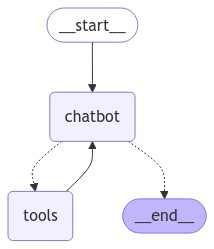

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", input("User: "))]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

User:  AI agent에 대해 조사하고, 이를 그림으로 표현해줘


================================ Human Message =================================

AI agent에 대해 조사하고, 이를 그림으로 표현해줘
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_OEJI78BUYwa9fzzWr7jYsKz4)
 Call ID: call_OEJI78BUYwa9fzzWr7jYsKz4
  Args:
    query: AI agent 개념 및 정의
  generate_image (call_mWIShUVXnZVeY14pqdZETjDR)
 Call ID: call_mWIShUVXnZVeY14pqdZETjDR
  Args:
    prompt: A conceptual illustration of an AI agent, depicted as a futuristic humanoid robot interacting with digital interfaces, surrounded by abstract representations of data and technology. The setting is a modern, high-tech environment with glowing screens and holograms, conveying a sense of advanced intelligence and innovation.
================================= Tool Message =================================
Name: generate_image

https://oaidalleapiprodscus.blob.core.windows.net/private/org-Lo7XKfsnK3jBFRzYS0reljkM/user-UHvHQUo1fD5Fg83cucq6xpgs/img